# Advanced Lane Line Finding

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import numpy as np
import cv2
import os
import glob
from moviepy.editor import VideoFileClip

## Camera Calibration

In [2]:
calibration_images = glob.glob('./camera_cal/calibration*.jpg')
# number of inside corners in x
nx = 9
# number of inside corners in y
ny = 6

object_points = []
image_points = []

object_point = np.zeros((nx * ny, 3), np.float32)
object_point[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

for idx, file in enumerate(calibration_images):
    image = cv2.imread(file)
    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray_image, (nx, ny), None)
    # If found, save corners
    if ret == True:
        object_points.append(object_point)
        image_points.append(corners)

# Camera calibration
image_size = (image.shape[1], image.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points, image_size, None, None)

# Camera calibration data
calibrated_data = {'mtx': mtx, 'dist': dist}

### Example

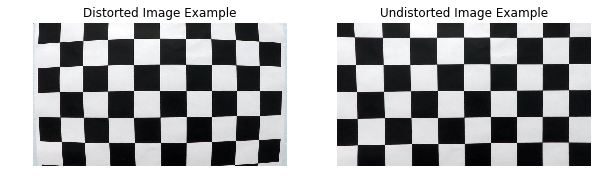

In [3]:
distorted_image_example = './camera_cal/calibration1.jpg'
distorted_image_example = cv2.imread(distorted_image_example)
undistorted_image_example = cv2.undistort(distorted_image_example, calibrated_data['mtx'], calibrated_data['dist'], None, calibrated_data['mtx'])

# Display both distorted and undistorted images
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('Distorted Image Example')
plt.imshow(distorted_image_example)

plt.subplot(1, 2, 2)
plt.axis('off')
plt.title('Undistorted Image Example')
plt.imshow(undistorted_image_example)

### Correcting for Distortion

In [4]:
calibration_output_images = './output_images/camera_cal/'

for idx, file in enumerate(calibration_images):
    image = cv2.imread(file)
    undistorted_image = cv2.undistort(distorted_image_example, calibrated_data['mtx'], calibrated_data['dist'], None, calibrated_data['mtx'])
    # Save undistorted image
    output = calibration_output_images + file[file.rindex('/') + 1:file.rindex('.')] + '.jpg'
    cv2.imwrite(output, undistorted_image)

### Example

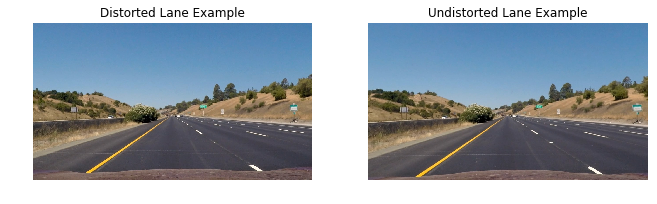

In [5]:
lane_example = './test_images/straight_lines1.jpg'
lane_example = cv2.imread(lane_example)
undistorted_lane_example = cv2.undistort(lane_example, calibrated_data['mtx'], calibrated_data['dist'], None, calibrated_data['mtx'])

plt.figure(figsize=(11, 6))

plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('Distorted Lane Example')
plt.imshow(cv2.cvtColor(lane_example, cv2.COLOR_BGR2RGB))

plt.subplot(1, 2, 2)
plt.axis('off')
plt.title('Undistorted Lane Example')
plt.imshow(cv2.cvtColor(undistorted_lane_example, cv2.COLOR_BGR2RGB))


### Correcting for Distortion

In [6]:
lane_test_images = os.listdir('./test_images/')
lane_test_output_images = './output_images/test_images/'

for file in lane_test_images:
    image = cv2.imread('./test_images/' + file)
    undistorted_image = cv2.undistort(image, calibrated_data['mtx'], calibrated_data['dist'], None, calibrated_data['mtx'])
    # Save undistorted image
    output = lane_test_output_images + file
    cv2.imwrite(output, undistorted_image)

## Create Thresholded Binary Images

In [7]:
def pipeline(image, gray_thresh=(20, 255), s_thresh=(170, 255), l_thresh=(30, 255), sobel_kernel=3):
    # first we take a copy of the source iamge
    image_copy = np.copy(image)
    
    # convert RGB image to HLS color space.
    # HLS more reliable when it comes to find out lane lines
    hls = cv2.cvtColor(image_copy, cv2.COLOR_RGB2HLS)
    s_channel = hls[:, :, 2]
    l_channel = hls[:, :, 1]

    # Next, we apply Sobel operator in X direction and calculate scaled derivatives.
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))

    # Next, we generate a binary image based on gray_thresh values.
    thresh_min = gray_thresh[0]
    thresh_max = gray_thresh[1]
    sobel_x_binary = np.zeros_like(scaled_sobel)
    sobel_x_binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Next, we generated a binary image using S component of our HLS color scheme and
    # provided S threshold
    s_binary = np.zeros_like(s_channel)
    s_thresh_min = s_thresh[0]
    s_thresh_max = s_thresh[1]
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Next, we generated a binary image using S component of our HLS color scheme and
    # provided S threshold
    l_binary = np.zeros_like(l_channel)
    l_thresh_min = l_thresh[0]
    l_thresh_max = l_thresh[1]
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1

    # Finally, return the combined binary image
    binary = np.zeros_like(sobel_x_binary)
    binary[((l_binary == 1) & (s_binary == 1) | (sobel_x_binary == 1))] = 1
    binary = 255 * np.dstack((binary, binary, binary)).astype('uint8')

    return binary

### Example

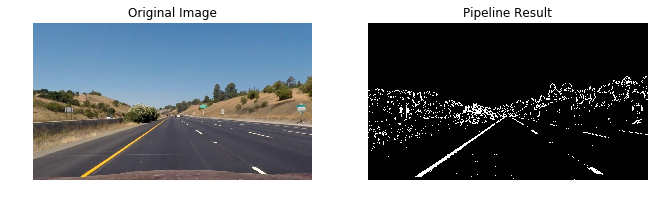

In [8]:
undistorted_lane_example = mpimg.imread('./output_images/test_images/straight_lines1.jpg')
undistorted_lane_example_result = pipeline(undistorted_lane_example, gray_thresh = (20, 255), s_thresh = (170, 255), l_thresh = (30, 255))

plt.figure(figsize=(11, 6))

plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('Original Image')
plt.imshow(undistorted_lane_example)

plt.subplot(1, 2, 2)
plt.axis('off')
plt.title('Pipeline Result')
plt.imshow(undistorted_lane_example_result)

### Pipeline

In [10]:
lane_test_images = os.listdir('./output_images/test_images/')
lane_test_images_binary = './output_images/test_images_binary/'

for file in lane_test_images:
    image = mpimg.imread('./output_images/test_images/' + file)
    image_binary = pipeline(image, gray_thresh = (20, 255), s_thresh = (150, 255), l_thresh = (120, 255))
    # Save undistorted image
    output = lane_test_images_binary + file
    cv2.imwrite(output, image_binary)

## Perspective Transformation

In [11]:
image = mpimg.imread('./output_images/test_images/straight_lines1.jpg')

corners = np.float32([[253, 697],[585,456],[700, 456],[1061,690]])
new_top_left = np.array([corners[0, 0], 0])
new_top_right = np.array([corners[3, 0], 0])
offset = [50, 0]

img_size = (image.shape[1], image.shape[0])
src = np.float32([corners[0], corners[1], corners[2], corners[3]])
dst = np.float32([corners[0] + offset, new_top_left + offset, new_top_right - offset, corners[3] - offset])

def transformer(image, src_points, dest_points):
    M = cv2.getPerspectiveTransform(src_points, dest_points)
    size = (image.shape[1], image.shape[0])
    return cv2.warpPerspective(image, M, size, flags=cv2.INTER_LINEAR)

def inverse_transformer(image, src_points, dest_points):
    M = cv2.getPerspectiveTransform(dest_points, src_points)
    size = (image.shape[1], image.shape[0])
    return cv2.warpPerspective(image, M, size, flags=cv2.INTER_LINEAR)

### Example

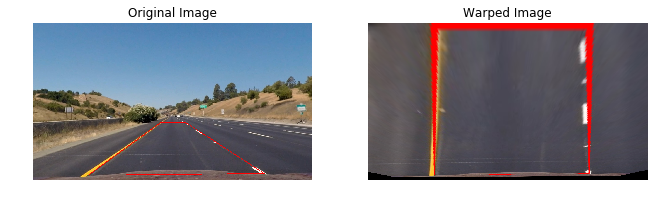

In [12]:
cv2.line(image, (253,  697), (585,  456), color=[255,0,0], thickness=2)
cv2.line(image, (585,  456), (700,  456), color=[255,0,0], thickness=2)
cv2.line(image, (700,  456), (1061, 690), color=[255,0,0], thickness=2)
cv2.line(image, (1061, 690), (253,  697), color=[255,0,0], thickness=2)

warped_img = transformer(image, src, dst)

plt.figure(figsize=(11, 5))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('Original Image')
plt.imshow(image)

plt.subplot(1, 2, 2)
plt.axis('off')
plt.title('Warped Image')
plt.imshow(warped_img)

### Transform

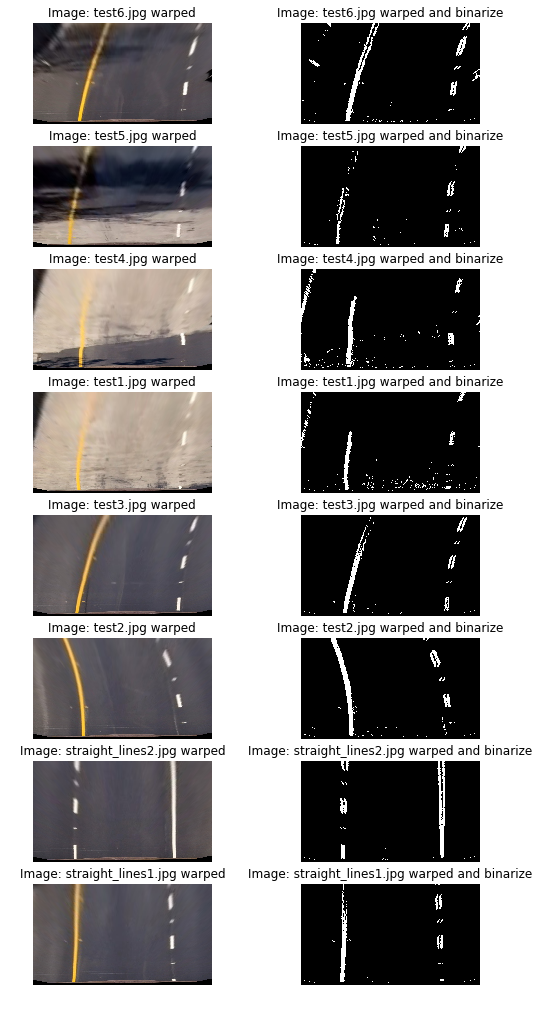

In [13]:
index = 0
plt.figure(figsize=(8, 18))
gs = gridspec.GridSpec(8, 2)
gs.update(wspace=0.5, hspace=0.05)

binary_images = []
for file in os.listdir('./output_images/test_images/'):
    image = mpimg.imread('./output_images/test_images/' + file)
        
    ax1 = plt.subplot(gs[index])
    undistorted = transformer(image, src, dst)
    ax1.axis('off')
    ax1.set_title('Image: {} warped'.format(file))
    ax1.imshow(undistorted)
    
    index += 1
    
    binary_img = pipeline(undistorted)
    binary_images.append(binary_img)
    ax2 = plt.subplot(gs[index])
    ax2.axis('off')
    ax2.set_title('Image: {} warped and binarize'.format(file))
    ax2.imshow(binary_img)
    
    index += 1


## Calculate Lane Curvature

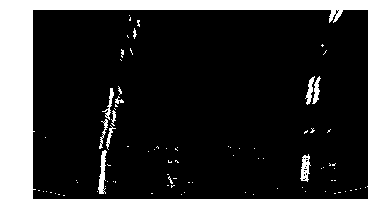

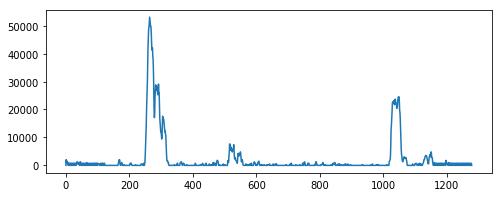

In [14]:
warped_image = binary_images[1] 
plt.imshow(warped_image)
plt.axis('off')

histogram = np.sum(warped_image[warped_image.shape[0] // 2:, :, 0], axis=0)
plt.figure(figsize=(8, 3))
plt.plot(histogram)


(720, 0)

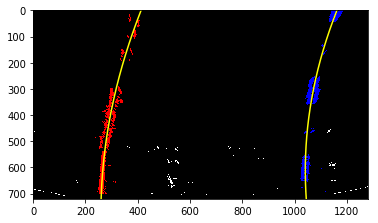

In [15]:
midpoint = np.int(histogram.shape[0] / 2)

# get left and right halves of the histogram
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

nwindows = 9
window_height = np.int(warped_image.shape[0] / nwindows)

# Extracts x and y coordinates of non-zero pixels
nonzero = warped_image.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# Set current x coordinated for left and right
leftx_current = leftx_base
rightx_current = rightx_base

margin = 75
min_num_pixels = 35

# save pixel ids in these two lists
left_lane_inds = []
right_lane_inds = []

for window in range(nwindows):
    win_y_low = warped_image.shape[0] - (window + 1) * window_height
    win_y_high = warped_image.shape[0] - window * window_height

    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin

    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                      (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                       (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)

    if len(good_left_inds) > min_num_pixels:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > min_num_pixels:
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the ndarrays of indices
left_lane_array = np.concatenate(left_lane_inds)
right_lane_array = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_array]
lefty = nonzeroy[left_lane_array]
rightx = nonzerox[right_lane_array]
righty = nonzeroy[right_lane_array]

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

fity = np.linspace(0, warped_image.shape[0] - 1, warped_image.shape[0])
fit_leftx = left_fit[0] * fity ** 2 + left_fit[1] * fity + left_fit[2]
fit_rightx = right_fit[0] * fity ** 2 + right_fit[1] * fity + right_fit[2]


warped_image[nonzeroy[left_lane_array], nonzerox[left_lane_array]] = [255, 0, 0]
warped_image[nonzeroy[right_lane_array], nonzerox[right_lane_array]] = [0, 0, 255]
plt.imshow(warped_image)
plt.plot(fit_leftx, fity, color='yellow')
plt.plot(fit_rightx, fity, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

## Output Images And Videos

In [16]:
# the characteristics of each lane detection
lane_detected = False

lane_left_fit = None
lane_right_fit = None

lane_max_buffer_size = 12

lane_buffer_index = 0
lane_iter_counter = 0

lane_buffer_left = np.zeros((lane_max_buffer_size, 720))
lane_buffer_right = np.zeros((lane_max_buffer_size, 720))

In [17]:
def extractor(image):
    global lane_detected
    global lane_left_fit
    global lane_right_fit
    global lane_max_buffer_size
    global lane_buffer_index
    global lane_iter_counter
    global lane_buffer_left
    global lane_buffer_right

    margin = 75
    
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # save pixel ids in these two lists
    left_lane_inds = []
    right_lane_inds = []
    
    if lane_detected:
        # Assume you now have a new warped binary image
        # from the next frame of video
        # It's now much easier to find line pixels!
        left_lane_inds = ((nonzerox > (lane_left_fit[0] * (nonzeroy ** 2) + lane_left_fit[1] * nonzeroy + lane_left_fit[2] - margin)) & (nonzerox < (lane_left_fit[0] * (nonzeroy ** 2) + lane_left_fit[1] * nonzeroy + lane_left_fit[2] + margin)))
        right_lane_inds = ((nonzerox > (lane_right_fit[0] * (nonzeroy ** 2) + lane_right_fit[1] * nonzeroy + lane_right_fit[2] - margin)) & (nonzerox < (lane_right_fit[0] * (nonzeroy ** 2) + lane_right_fit[1] * nonzeroy + lane_right_fit[2] + margin)))
    else:
        histogram = np.sum(image[image.shape[0] // 2:, :, 0], axis=0)

        # get midpoint of the histogram
        midpoint = np.int(histogram.shape[0] / 2)

        # get left and right halves of the histogram
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # based on number of events, we calculate hight of a window
        nwindows = 9
        window_height = np.int(image.shape[0] / nwindows)

        # Set current x coordinated for left and right
        leftx_current = leftx_base
        rightx_current = rightx_base

        min_num_pixels = 35

        for window in range(nwindows):
            win_y_low = image.shape[0] - (window + 1) * window_height
            win_y_high = image.shape[0] - window * window_height

            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin

            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            if len(good_left_inds) > min_num_pixels:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > min_num_pixels:
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        lane_detected = True

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    lane_left_fit = np.polyfit(lefty, leftx, 2)
    lane_right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    fity = np.linspace(0, image.shape[0] - 1, image.shape[0])
    fit_leftx = lane_left_fit[0] * fity ** 2 + lane_left_fit[1] * fity + lane_left_fit[2]
    fit_rightx = lane_right_fit[0] * fity ** 2 + lane_right_fit[1] * fity + lane_right_fit[2]

    return fit_leftx, fit_rightx

In [18]:
 def calculate(image_size, left_x, right_x):
    global lane_detected
    global lane_left_fit
    global lane_right_fit
    global lane_max_buffer_size
    global lane_buffer_index
    global lane_iter_counter
    global lane_buffer_left
    global lane_buffer_right
    
    # first we calculate the intercept points at the bottom of our image
    left_intercept = lane_left_fit[0] * image_size[0] ** 2 + lane_left_fit[1] * image_size[0] + lane_left_fit[2]
    right_intercept = lane_right_fit[0] * image_size[0] ** 2 + lane_right_fit[1] * image_size[0] + lane_right_fit[2]

    # Next take the difference in pixels between left and right interceptor points
    road_width_in_pixels = right_intercept - left_intercept
    assert road_width_in_pixels > 0, 'Road width in pixel can not be negative'

    # Since average highway lane line width in US is about 3.7m
    # Source: https://en.wikipedia.org/wiki/Lane#Lane_width
    # we calculate length per pixel in meters
    meters_per_pixel_x_dir = 3.7 / road_width_in_pixels
    meters_per_pixel_y_dir = 30 / road_width_in_pixels

    # Recalculate road curvature in X-Y space
    ploty = np.linspace(0, 719, num=720)
    y_eval = np.max(ploty)

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty * meters_per_pixel_y_dir, left_x * meters_per_pixel_x_dir, 2)
    right_fit_cr = np.polyfit(ploty * meters_per_pixel_y_dir, right_x * meters_per_pixel_x_dir, 2)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * meters_per_pixel_y_dir + left_fit_cr[1]) ** 2) ** 1.5) / np.absolute(2 * left_fit_cr[0])
    right_curverad = ((1 + (2 * right_fit_cr[0] * y_eval * meters_per_pixel_y_dir + right_fit_cr[1]) ** 2) ** 1.5) / np.absolute(2 * right_fit_cr[0])

    # Next, we can lane deviation
    calculated_center = (left_intercept + right_intercept) / 2.0
    lane_deviation = (calculated_center - image_size[1] / 2.0) * meters_per_pixel_x_dir

    return left_curverad, right_curverad, lane_deviation

In [19]:
def process(image):
    global lane_detected
    global lane_left_fit
    global lane_right_fit
    global lane_max_buffer_size
    global lane_buffer_index
    global lane_iter_counter
    global lane_buffer_left
    global lane_buffer_right
    
    image = np.copy(image)
    undistorted_image = cv2.undistort(image, calibrated_data['mtx'], calibrated_data['dist'], None, calibrated_data['mtx'])
    warped_image = transformer(image, src, dst)
    binary_image = pipeline(warped_image)

    fit_leftx, fit_rightx = extractor(binary_image)
    
    lane_buffer_left[lane_buffer_index] = fit_leftx
    lane_buffer_right[lane_buffer_index] = fit_rightx

    lane_buffer_index += 1
    lane_buffer_index %= lane_max_buffer_size
    
    if lane_iter_counter < lane_max_buffer_size:
        lane_iter_counter += 1
        ave_left = np.sum(lane_buffer_left, axis=0) / lane_iter_counter
        ave_right = np.sum(lane_buffer_right, axis=0) / lane_iter_counter
    else:
        ave_left = np.average(lane_buffer_left, axis=0)
        ave_right = np.average(lane_buffer_right, axis=0)
    
    left_curvature, right_curvature, calculated_deviation = calculate(image.shape, ave_left, ave_right)
    
    # print curvature, deviation info
    curvature_text = 'Left Curvature: {:.2f} m    Right Curvature: {:.2f} m'.format(left_curvature, right_curvature)
    cv2.putText(image, curvature_text, (100, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (221, 28, 119), 2)

    deviation_info = 'Lane Deviation: {:.3f} m'.format(calculated_deviation)
    cv2.putText(image, deviation_info, (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1, (221, 28, 119), 2)
    
    # draw lane
    lane_image = np.zeros_like(image)
    fit_y = np.linspace(0, lane_image.shape[0] - 1, lane_image.shape[0])
    pts_left = np.array([np.transpose(np.vstack([ave_left, fit_y]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([ave_right, fit_y])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(lane_image, np.int_([pts]), (0, 255, 0))
    
    lane_image = np.copy(lane_image)
    image = np.copy(image)
    lane_image = inverse_transformer(lane_image, src, dst)
    result = cv2.addWeighted(image, 1, lane_image, 0.3, 0)
    
    return result

### Example

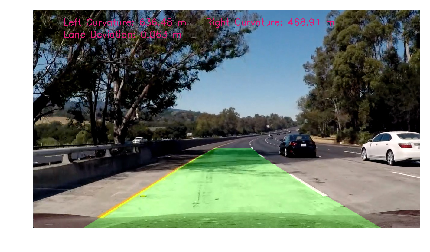

In [20]:
image = mpimg.imread('./test_images/test5.jpg')

output_image = process(image)

plt.figure(figsize=(10, 4))
plt.axis('off')
plt.imshow(output_image)

### Output

In [21]:
input_video = './project_video.mp4'
output_video = './output_videos/project_video.mp4'


clip = VideoFileClip(input_video)
out_clip = clip.fl_image(process) 
out_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video ./output_videos/project_video.mp4
[MoviePy] Writing video ./output_videos/project_video.mp4


100%|█████████▉| 1260/1261 [02:25<00:00,  8.73it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/project_video.mp4 

